<p style="text-align: center;"><img alt="school-logo" src="../images/school_logo.png" style="zoom: 50%;" /></p>

<h1 align="center">本科生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">网络优化实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">21281280</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">班级</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">物联网2101班</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">指导老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">张淳杰</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2023年11月20日</span></div>
</div>

实验环境：
- OS：Ubuntu 22.04.3 LTS (GNU/Linux 6.2.0-36-generic x86_64)
- CPU：12th Gen Intel(R) Core(TM) i7-12700H
- GPU：NVIDIA GeForce RTX 3070 Ti Laptop
- cuda: 12.3
- conda: miniconda 23.9.0
- python：3.10.13
- torch：2.1.1

In [1]:
import numpy as np
import torch
from torch.nn.functional import *
from torch.utils.data import DataLoader, random_split
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

引用必要的库。

# 任务一

**在多分类任务实验中分别手动实现和用torch.nn实现dropout**

- 探究不同丢弃率对实验结果的影响（可用loss曲线进行展示）


In [2]:
class MNIST_CLS_Model(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=1024)
        self.fc4 = nn.Linear(in_features=1024, out_features=256)
        self.fc5 = nn.Linear(in_features=256, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x


def train_MNIST_CLS(model, optimizer, num_epochs):
    batch_size = 8192
    num_classes = 10
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )
    train_mnist_dataset = datasets.MNIST(root="./dataset", train=True, transform=transform, download=True)
    test_mnist_dataset = datasets.MNIST(root="./dataset", train=False, transform=transform, download=True)
    train_loader = DataLoader(dataset=train_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
    test_loader = DataLoader(dataset=test_mnist_dataset, batch_size=batch_size, num_workers=14, pin_memory=True)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    train_loss = list()
    test_acc = list()
    for epoch in range(num_epochs):
        model.train()
        total_epoch_loss = 0
        for images, targets in train_loader:
            optimizer.zero_grad()

            images = images.to(device)
            targets = targets.to(device)
            one_hot_targets = one_hot(targets, num_classes=num_classes).to(dtype=torch.float)

            outputs = model(images)
            loss = criterion(outputs, one_hot_targets)
            total_epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            total_epoch_acc = 0
            for image, targets in test_loader:
                image = image.to(device)
                targets = targets.to(device)
                
                outputs = model(image)
                pred = softmax(outputs, dim=1)
                total_epoch_acc += (pred.argmax(1) == targets).sum().item()
        
        avg_epoch_acc = total_epoch_acc / len(test_mnist_dataset)
        if epoch % 40 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}],",
                f"Train Loss: {total_epoch_loss:.10f},",
                f"Test Acc: {avg_epoch_acc * 100:.3f}%",
            )
        train_loss.append(total_epoch_loss)
        test_acc.append(avg_epoch_acc * 100)
    return train_loss, test_acc

首先编写训练模型的框架函数代码。

In [3]:
class My_Dropout(nn.Module):
    def __init__(self, p, **kwargs):
        super().__init__()
        self.p = p
        self.mask = None

    def forward(self, x:torch.Tensor):
        if self.training:
            self.mask = (torch.rand(x.shape) > self.p).to(dtype=torch.float32, device=x.device)
            return x * self.mask / (1 - self.p)
        else:
            return x


# 测试
my_dropout = My_Dropout(p=0.5)
nn_dropout = nn.Dropout(p=0.5)
x = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0],
                  [6.0, 7.0, 8.0, 9.0, 10.0]])
print(f"输入：\n{x}")
output_my_dropout = my_dropout(x)
output_nn_dropout = nn_dropout(x)
print(f"My_Dropout输出：\n{output_my_dropout}")
print(f"nn.Dropout输出：\n{output_nn_dropout}")

输入：
tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10.]])
My_Dropout输出：
tensor([[ 2.,  0.,  6.,  8.,  0.],
        [ 0., 14.,  0., 18.,  0.]])
nn.Dropout输出：
tensor([[ 0.,  4.,  6.,  0., 10.],
        [12., 14.,  0.,  0.,  0.]])


手动实现Dropout。

dropout_rate=0.0
Epoch [1/161], Train Loss: 18.3612053394, Test Acc: 10.540%
Epoch [41/161], Train Loss: 2.2243138552, Test Acc: 92.090%
Epoch [81/161], Train Loss: 1.4333713949, Test Acc: 94.850%
Epoch [121/161], Train Loss: 1.0422569066, Test Acc: 95.950%
Epoch [161/161], Train Loss: 0.7250142395, Test Acc: 96.640%
dropout_rate=0.25
Epoch [1/161], Train Loss: 18.3689846992, Test Acc: 25.860%
Epoch [41/161], Train Loss: 2.3589982688, Test Acc: 91.930%
Epoch [81/161], Train Loss: 1.4811040908, Test Acc: 94.560%
Epoch [121/161], Train Loss: 1.0563187748, Test Acc: 96.140%
Epoch [161/161], Train Loss: 1.3523552120, Test Acc: 95.800%
dropout_rate=0.5
Epoch [1/161], Train Loss: 18.3639202118, Test Acc: 29.560%
Epoch [41/161], Train Loss: 2.6411375999, Test Acc: 91.350%
Epoch [81/161], Train Loss: 1.5525230914, Test Acc: 94.640%
Epoch [121/161], Train Loss: 1.1174016893, Test Acc: 96.200%
Epoch [161/161], Train Loss: 0.8520765156, Test Acc: 96.710%
dropout_rate=0.75
Epoch [1/161], Train Los

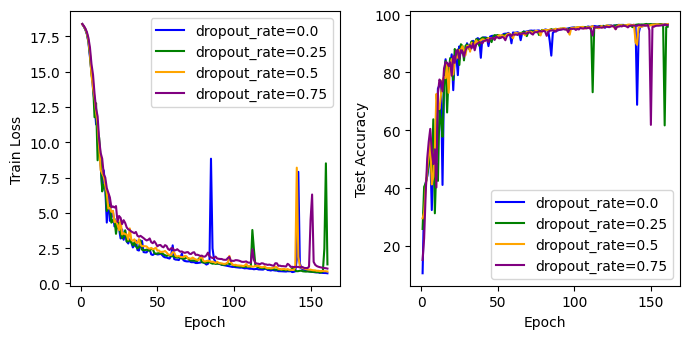

In [4]:
learning_rate = 8e-2
num_epochs = 161
plt.figure(figsize=(7, 3.5))
color = ["blue", "green", "orange", "purple"]
for i in np.arange(4):
    dropout_rate = i / 4
    model = MNIST_CLS_Model(num_classes=10, dropout_rate=dropout_rate)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    print(f"dropout_rate={dropout_rate}")
    train_loss, test_acc = train_MNIST_CLS(model, optimizer, num_epochs=num_epochs)
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_loss, label=f'dropout_rate={dropout_rate}', color=color[i])
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_acc, label=f'dropout_rate={dropout_rate}', color=color[i])
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

可以看出，丢弃率越高，loss就会越高，因为丢弃部分神经元会导致网络在训练时失去了一些有用的信息，因为每个神经元都对模型的表达能力有贡献。如果丢弃率很高，网络可能无法充分利用所有的特征，导致信息的损失。

但是，丢弃率越高，测试集的正确率提升相对更稳定。因为高丢弃率使得模型更多地依赖于共享的特征而不是过分依赖于个别神经元，有助于防止过拟合。在丢弃率为$0.5$以下时，容易发生过拟合。但是当丢弃率为$0.5$以上时，就很少发生过拟合的现象。

# 任务二

**在多分类任务实验中分别手动实现和用torch.nn实现$L_2$正则化**

- 探究惩罚项的权重对实验结果的影响（可用loss曲线进行展示）


对于$L_2$正则化，pytorch的的实现是将$L_2$正则化的系数作为优化器的`weight_decay`参数传入，在`step()`的过程中计算完成。具体原理如下：

$L_2$正则化的公式是

$$
L = L_0 + \frac{\lambda }{2n} \sum_{w}w^2
$$

其中$L$是进行$L_2$正则化后的损失，$L_0$是损失函数计算出来的原损失，$\lambda$是$L_2$正则化系数（即optimizer的`weight_decay`参数），$n$是样本大小。

反向传播：

$$
\begin{align}
\frac{\partial L}{\partial w} & = \frac{\partial L_0}{\partial w}+\frac{\lambda }{n} w \\
\frac{\partial L}{\partial b} & = \frac{\partial L_0}{\partial b}
\end{align}
$$

所以，参数更新为：

$$
\begin{align}
w: & = w-\frac{\eta \lambda }{n}w- \frac{\eta}{n}\sum\frac{\partial L_0}{\partial w} \\
b: & = b-\frac{\eta}{n}\sum\frac{\partial L_0}{\partial b}
\end{align}
$$

其中$\eta$是学习率。

所以，手动在优化器中实现$L_2$正则化如下：

In [5]:
class My_SGD:
    def __init__(self, params: list[torch.Tensor], lr: float, weight_decay=0.0):
        self.params = params
        self.lr = lr
        self.weight_decay = weight_decay

    def step(self):
        with torch.no_grad():
            for param in self.params:
                if param.grad is not None:
                    if len(param.data.shape) > 1:
                        param.data = param.data - self.lr * (param.grad + self.weight_decay * param.data)
                    else:
                        param.data = param.data - self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data = torch.zeros_like(param.grad.data)


# 测试
params1 = torch.tensor([[1., 2, ]], requires_grad=True)
params2 = torch.tensor([[1., 2, ]], requires_grad=True)

my_sgd = My_SGD(params=[params1], lr=0.5, weight_decay=0.1)
optim_sgd = torch.optim.SGD(params=[params2], lr=0.5, weight_decay=0.1)
my_sgd.zero_grad()
optim_sgd.zero_grad()

loss1 = 2 * params1.sum()
loss2 = 2 * params2.sum()
 # 偏导为2
loss1.backward()
loss2.backward()
print("params1的梯度为：\n", params1.grad.data)
print("params2的梯度为：\n", params2.grad.data)

my_sgd.step()
optim_sgd.step()
# 结果为：w - lr * grad - lr * weight_decay_rate * w
# w[0] = 1 - 0.5 * 2 - 0.5 * 0.1 * 1 = -0.0500
# w[1] = 2 - 0.5 * 2 - 0.5 * 0.1 * 2 = 0.9000
print("经过L_2正则化后的My_SGD反向传播结果：\n", params1.data)
print("经过L_2正则化后的torch.optim.SGD反向传播结果：\n", params2.data)

params1的梯度为：
 tensor([[2., 2.]])
params2的梯度为：
 tensor([[2., 2.]])
经过L_2正则化后的My_SGD反向传播结果：
 tensor([[-0.0500,  0.9000]])
经过L_2正则化后的torch.optim.SGD反向传播结果：
 tensor([[-0.0500,  0.9000]])


weight_decay_rate=0.0
Epoch [1/161], Train Loss: 18.3586504459, Test Acc: 11.350%
Epoch [41/161], Train Loss: 2.2273855805, Test Acc: 91.870%
Epoch [81/161], Train Loss: 1.4378820062, Test Acc: 94.420%
Epoch [121/161], Train Loss: 0.9473107532, Test Acc: 96.220%
Epoch [161/161], Train Loss: 0.9763946906, Test Acc: 95.850%
weight_decay_rate=0.0025
Epoch [1/161], Train Loss: 18.3720602989, Test Acc: 11.790%
Epoch [41/161], Train Loss: 2.4159298837, Test Acc: 90.460%
Epoch [81/161], Train Loss: 1.6433586627, Test Acc: 94.170%
Epoch [121/161], Train Loss: 1.5564490259, Test Acc: 94.790%
Epoch [161/161], Train Loss: 1.7672693580, Test Acc: 62.780%
weight_decay_rate=0.005
Epoch [1/161], Train Loss: 18.3529415131, Test Acc: 20.810%
Epoch [41/161], Train Loss: 3.0496689975, Test Acc: 86.750%
Epoch [81/161], Train Loss: 1.7128281891, Test Acc: 93.060%
Epoch [121/161], Train Loss: 1.4363404214, Test Acc: 94.830%
Epoch [161/161], Train Loss: 1.1253674477, Test Acc: 95.720%
weight_decay_rate=0.007

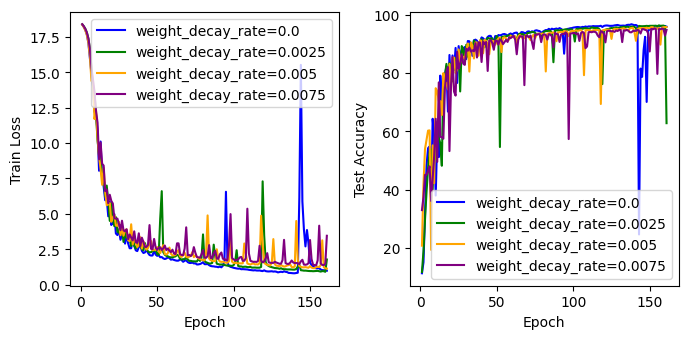

In [6]:
learning_rate = 8e-2
num_epochs = 161
plt.figure(figsize=(7, 3.5))
color = ["blue", "green", "orange", "purple"]
for i in np.arange(4):
    weight_decay_rate = i / 4 * 0.01
    model = MNIST_CLS_Model(num_classes=10, dropout_rate=0)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)
    print(f"weight_decay_rate={weight_decay_rate}")
    train_loss, test_acc = train_MNIST_CLS(model, optimizer, num_epochs=num_epochs)
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_loss, label=f'weight_decay_rate={weight_decay_rate}', color=color[i])
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_acc, label=f'weight_decay_rate={weight_decay_rate}', color=color[i])
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

可以看出$L_2$正则化（即weight decay）的系数越大，loss越大。因为weight decay对权重进行了惩罚，防止其过拟合，导致其介于欠拟合和过拟合之间。在本实验中没有出现过拟合的情况，所以weight decay发挥效果不稳定，大多数情况反而导致正确率有所下降。

# 任务三

**在多分类任务实验中实现momentum、rmsprop、adam优化器**

- 在手动实现多分类的任务中手动实现三种优化算法，并补全Adam中计算部分的内容
- 在torch.nn实现多分类的任务中使用torch.nn实现各种优化器，并对比其效果


首先实现momentum。

参数更新为：

$$
\begin{align}
w: & = w- \frac{\eta}{n}\sum\frac{\partial L_0}{\partial w} + \beta_1{\left(-\frac{\eta}{n}\sum\frac{\partial L_0}{\partial w}\right)}_{step-1} \\
b: & = b-\frac{\eta}{n}\sum\frac{\partial L_0}{\partial b} + \beta_1{\left(-\frac{\eta}{n}\sum\frac{\partial L_0}{\partial b}\right)}_{step-1}
\end{align}
$$

其中$\beta_1$为momentum的系数。

完善任务二中的My_SGD，加入momentum。

In [7]:
class My_SGD:
    def __init__(self, params: list[torch.Tensor], lr: float, weight_decay=0.0, momentum=0.0):
        self.params = params
        self.lr = lr
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.velocities = [torch.zeros_like(param.data) for param in params]

    def step(self):
        with torch.no_grad():
            for index, param in enumerate(self.params):
                if param.grad is not None:
                    if self.weight_decay > 0:
                        if len(param.data.shape) > 1:
                            param.grad.data = param.grad.data + self.weight_decay * param.data
                    self.velocities[index] = self.momentum * self.velocities[index] - self.lr * param.grad
                    param.data = param.data + self.velocities[index]

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data = torch.zeros_like(param.grad.data)


# 测试
params1 = torch.tensor([[1., 2, ]], requires_grad=True)
params2 = torch.tensor([[1., 2, ]], requires_grad=True)

my_sgd = My_SGD(params=[params1], lr=0.5, momentum=1)
optim_sgd = torch.optim.SGD(params=[params2], lr=0.5, momentum=1)
my_sgd.zero_grad()
optim_sgd.zero_grad()

loss1 = 2 * params1.sum()
loss2 = 2 * params2.sum()
# 偏导为2
loss1.backward()
loss2.backward()
my_sgd.step()
optim_sgd.step()
# 结果为：w - lr * grad + momentum * velocity
# w[0] = 1 - 0.5 * 2 + 1 * 0 = 0
# w[1] = 2 - 0.5 * 2 + 1 * 0 = 1
print("My_SGD第1次反向传播结果：\n", params1.data)
print("torch.optim.SGD第1次反向传播结果：\n", params2.data)

my_sgd.zero_grad()
optim_sgd.zero_grad()
loss1 = -3 * params1.sum()
loss2 = -3 * params2.sum()
# 偏导为-3
loss1.backward()
loss2.backward()
my_sgd.step()
optim_sgd.step()
# 结果为：w - lr * grad + momentum * velocity
# w[0] = 0 - 0.5 * -3 + 1 * (-0.5 * 2) = 0.5
# w[1] = 1 - 0.5 * -3 + 1 * (-0.5 * 2) = 1.5
print("My_SGD第2次反向传播结果：\n", params1.data)
print("torch.optim.SGD第2次反向传播结果：\n", params2.data)

My_SGD第1次反向传播结果：
 tensor([[0., 1.]])
torch.optim.SGD第1次反向传播结果：
 tensor([[0., 1.]])
My_SGD第2次反向传播结果：
 tensor([[0.5000, 1.5000]])
torch.optim.SGD第2次反向传播结果：
 tensor([[0.5000, 1.5000]])


接下来实现RMSprop。

参数$w$更新为：

$$
\begin{align}
s: & = \alpha s+\left(1-\alpha\right) {\left(\frac{1}{n}\sum\frac{\partial L_0}{\partial w}\right)}^2 \\
w: & = w- \eta\frac{s}{\sqrt{s+\beta_1} }  \\
\end{align}
$$

其中$\alpha_1$为RMSprop的超参数。参数$b$更新同理。

编写RMSprop。

In [8]:
class My_RMSprop:
    def __init__(self, params: list[torch.Tensor], lr=1e-2, alpha=0.99, eps=1e-8):
        self.params = params
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.square_avg = [torch.zeros_like(param.data) for param in params]
        

    def step(self):
        with torch.no_grad():
            for index, param in enumerate(self.params):
                if param.grad is not None:
                    self.square_avg[index] = self.alpha * self.square_avg[index] + (1 - self.alpha) * param.grad ** 2
                    param.data = param.data - self.lr * param.grad / torch.sqrt(self.square_avg[index] + self.eps)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data = torch.zeros_like(param.grad.data)


# 测试
params1 = torch.tensor([[1., 2, ]], requires_grad=True)
params2 = torch.tensor([[1., 2, ]], requires_grad=True)

my_sgd = My_RMSprop(params=[params1], lr=1, alpha=0.5, eps=1e-8)
optim_sgd = torch.optim.RMSprop(params=[params2], lr=1, alpha=0.5, eps=1e-8)
my_sgd.zero_grad()
optim_sgd.zero_grad()

loss1 = 2 * params1.sum()
loss2 = 2 * params2.sum()
# 偏导为2
loss1.backward()
loss2.backward()
my_sgd.step()
optim_sgd.step()
# s = alpha * s + (1-alpha) * grad^2 = 0.5 * 0 + (1-0.5) * 2^2 = 2
# w = w - lr * grad * (s + eps)^0.5
# w[0] = 1 - 1 * 2 / (2 + 1e-8)^0.5 ~= -0.41
# w[1] = 2 - 1 * 2 / (2 + 1e-8)^0.5 ~= -0.59
print("My_RMSprop第1次反向传播结果：\n", params1.data)
print("torch.optim.RMSprop第1次反向传播结果：\n", params2.data)

my_sgd.zero_grad()
optim_sgd.zero_grad()
loss1 = -3 * params1.sum()
loss2 = -3 * params2.sum()
# 偏导为-3
loss1.backward()
loss2.backward()
my_sgd.step()
optim_sgd.step()
# s = alpha * s + (1-alpha) * grad^2 = 0.5 * 2 + (1-0.5) * (-3)^2 = 5.5
# w - lr * grad * (s + eps)^0.5
# w[0] = -0.41 - 1 * -3 / (5.5 + 1e-8)^0.5 ~= 0.87
# w[1] = 0.59 - 1 * -3 / (5.5 + 1e-8)^0.5 ~= 1.86
print("My_RMSprop第2次反向传播结果：\n", params1.data)
print("torch.optim.RMSprop第2次反向传播结果：\n", params2.data)

My_RMSprop第1次反向传播结果：
 tensor([[-0.4142,  0.5858]])
torch.optim.RMSprop第1次反向传播结果：
 tensor([[-0.4142,  0.5858]])
My_RMSprop第2次反向传播结果：
 tensor([[0.8650, 1.8650]])
torch.optim.RMSprop第2次反向传播结果：
 tensor([[0.8650, 1.8650]])


In [9]:
class My_Adam:
    def __init__(self, params: list[torch.Tensor], lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = betas[0]
        self.beta2 = betas[1]
        self.eps = eps
        self.t = 0
        self.momentums = [torch.zeros_like(param.data) for param in params]
        self.velocities = [torch.zeros_like(param.data) for param in params]

    def step(self):
        self.t += 1
        with torch.no_grad():
            for index, param in enumerate(self.params):
                if param.grad is not None:
                    self.momentums[index] = (self.beta1 * self.momentums[index] + (1 - self.beta1) * param.grad)
                    self.velocities[index] = (self.beta2 * self.velocities[index] + (1 - self.beta2) * param.grad**2)
                    momentums_hat = self.momentums[index] / (1 - self.beta1**self.t)
                    velocities_hat = self.velocities[index] / (1 - self.beta2**self.t)
                    param.data = param.data - self.lr * momentums_hat / (torch.sqrt(velocities_hat) + self.eps)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data = torch.zeros_like(param.grad.data)


if __name__ == "__main__":
    params1 = torch.tensor([[1.0, 2.0,]], requires_grad=True)
    params2 = torch.tensor([[1.0, 2.0,]], requires_grad=True)

    my_sgd = My_Adam(params=[params1], lr=1, betas=(0.5, 0.5), eps=1e-8)
    optim_sgd = torch.optim.Adam(params=[params2], lr=1, betas=(0.5, 0.5), eps=1e-8)
    my_sgd.zero_grad()
    optim_sgd.zero_grad()

    loss1 = 2 * params1.sum()
    loss2 = 2 * params2.sum()
    # 偏导为2
    loss1.backward()
    loss2.backward()
    my_sgd.step()
    optim_sgd.step()
    print("My_Adam第1次反向传播结果：\n", params1.data)
    print("torch.optim.Adam第1次反向传播结果：\n", params2.data)

    my_sgd.zero_grad()
    optim_sgd.zero_grad()
    loss1 = -3 * params1.sum()
    loss2 = -3 * params2.sum()
    # 偏导为-3
    loss1.backward()
    loss2.backward()
    my_sgd.step()
    optim_sgd.step()
    print("My_Adam第2次反向传播结果：\n", params1.data)
    print("torch.optim.Adam第2次反向传播结果：\n", params2.data)

My_Adam第1次反向传播结果：
 tensor([[0., 1.]])
torch.optim.Adam第1次反向传播结果：
 tensor([[0., 1.]])
My_Adam第2次反向传播结果：
 tensor([[0.4924, 1.4924]])
torch.optim.Adam第2次反向传播结果：
 tensor([[0.4924, 1.4924]])


optimizer: SGD
Epoch [1/161], Train Loss: 18.4296679497, Test Acc: 12.410%
Epoch [41/161], Train Loss: 16.6156928539, Test Acc: 52.890%
Epoch [81/161], Train Loss: 6.2243856192, Test Acc: 80.030%
Epoch [121/161], Train Loss: 3.7015175521, Test Acc: 86.980%
Epoch [161/161], Train Loss: 3.0445261896, Test Acc: 89.070%
optimizer: RMSprop
Epoch [1/161], Train Loss: 417.8901937008, Test Acc: 15.990%
Epoch [41/161], Train Loss: 1.2281078026, Test Acc: 88.820%
Epoch [81/161], Train Loss: 1.6108630896, Test Acc: 95.610%
Epoch [121/161], Train Loss: 0.4748786949, Test Acc: 97.650%
Epoch [161/161], Train Loss: 0.6687553413, Test Acc: 97.190%
optimizer: Adam
Epoch [1/161], Train Loss: 15.9746286869, Test Acc: 68.570%
Epoch [41/161], Train Loss: 0.0055657097, Test Acc: 98.470%
Epoch [81/161], Train Loss: 0.0004255227, Test Acc: 98.460%
Epoch [121/161], Train Loss: 0.0001335207, Test Acc: 98.460%
Epoch [161/161], Train Loss: 0.0000606167, Test Acc: 98.400%


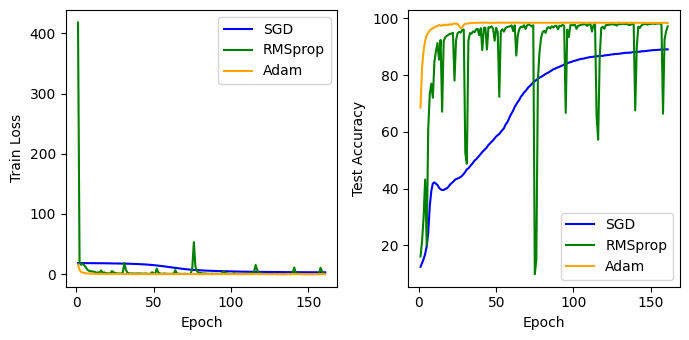

In [10]:
learning_rate = 1e-3
num_epochs = 161
plt.figure(figsize=(7, 3.5))

model = MNIST_CLS_Model(num_classes=10, dropout_rate=0)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
print(f"optimizer: SGD")
train_loss, test_acc = train_MNIST_CLS(model, optimizer, num_epochs=num_epochs)
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss, label="SGD", color="blue")
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_acc, label="SGD", color="blue")

model = MNIST_CLS_Model(num_classes=10, dropout_rate=0)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-8)
print(f"optimizer: RMSprop")
train_loss, test_acc = train_MNIST_CLS(model, optimizer, num_epochs=num_epochs)
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss, label="RMSprop", color="green")
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_acc, label="RMSprop", color="green")

model = MNIST_CLS_Model(num_classes=10, dropout_rate=0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8)
print(f"optimizer: Adam")
train_loss, test_acc = train_MNIST_CLS(model, optimizer, num_epochs=num_epochs)
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss, label="Adam", color="orange")
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_acc, label="Adam", color="orange")

plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

从实验结果看：

- 在`SGD`中应用momentum，效果较为稳定，但是需要较大的学习率和较多的训练轮数才能达到良好的效果。
- `RMSprop`的训练过程不稳定，尤其是训练刚开始时，loss巨大，如果学习率较大，容易出现梯度爆炸，模型不能正常训练；
- `Adam`效果较好，能够迅速达到优秀的效果，但是学习率较高时，同样无法正常训练。

# 任务四

**对多分类任务实验中实现早停机制，并在测试集上测试。**

- 选择上述实验中效果最好的组合，手动将训练数据划分为训练集和验证集，实现早停机制，并在测试集上进行测试。训练集：验证集=8:2，早停轮数为5。

Epoch [1/161], Train Loss: 12.2845923901, Test Acc: 48.640%, Val Loss: 3.1191009283
Epoch [6/161], Train Loss: 2.2487579882, Test Acc: 90.830%, Val Loss: 0.6830908656
Epoch [11/161], Train Loss: 1.1002770066, Test Acc: 94.950%, Val Loss: 0.3718443066
Epoch [16/161], Train Loss: 0.6551254392, Test Acc: 96.450%, Val Loss: 0.2593539357
Epoch [21/161], Train Loss: 0.4071293250, Test Acc: 97.200%, Val Loss: 0.2089994848
Epoch [26/161], Train Loss: 0.2799520865, Test Acc: 97.490%, Val Loss: 0.1810068339
Epoch [31/161], Train Loss: 0.1668622196, Test Acc: 97.710%, Val Loss: 0.1702276319
Epoch [36/161], Train Loss: 0.1138065355, Test Acc: 97.810%, Val Loss: 0.1672033146
Epoch [41/161], Train Loss: 0.0686604744, Test Acc: 98.050%, Val Loss: 0.1577220634
Epoch [43/161], Train Loss: 0.0556522962, Test Acc: 97.960%, Val Loss: 0.1697444022
Early stopping after 43 epochs.


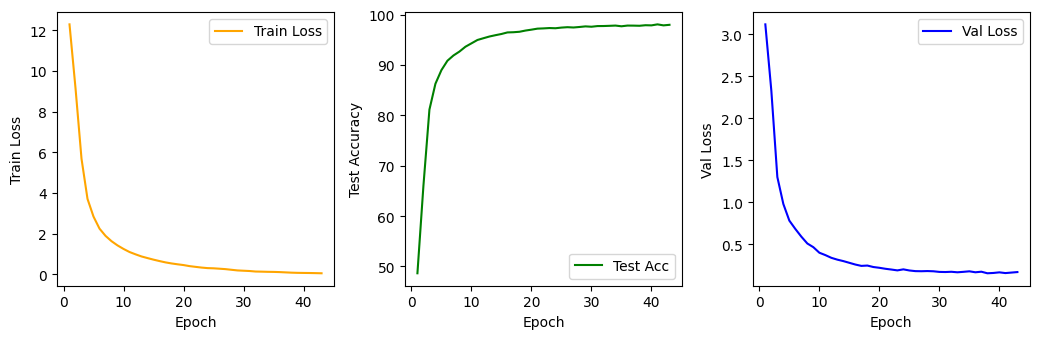

In [11]:
learning_rate = 5e-4
num_epochs = 161
batch_size = 8192
num_classes = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_mnist_dataset = datasets.MNIST(root="./dataset", train=True, transform=transform, download=True)
test_mnist_dataset = datasets.MNIST(root="./dataset", train=False, transform=transform, download=True)

train_dataset_length = int(0.8 * len(train_mnist_dataset))
val_dataset_length = len(train_mnist_dataset) - train_dataset_length
train_mnist_dataset, val_mnist_dataset = random_split(
    train_mnist_dataset,
    [train_dataset_length, val_dataset_length],
    generator=torch.Generator().manual_seed(42),
)

train_loader = DataLoader(dataset=train_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
val_loader = DataLoader(dataset=val_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
test_loader = DataLoader(dataset=test_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

model = MNIST_CLS_Model(num_classes=10, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)

early_stopping_patience = 5
best_val_loss = float("inf")
current_patience = 0

train_loss = list()
test_acc = list()
val_loss = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    for images, targets in train_loader:
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)
        one_hot_targets = one_hot(targets, num_classes=num_classes).to(dtype=torch.float)

        outputs = model(images)
        loss = criterion(outputs, one_hot_targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        for image, targets in test_loader:
            image = image.to(device)
            targets = targets.to(device)

            outputs = model(image)
            pred = softmax(outputs, dim=1)
            total_epoch_acc += (pred.argmax(1) == targets).sum().item()
        avg_epoch_acc = total_epoch_acc / len(test_mnist_dataset)

        val_total_epoch_loss = 0
        for image, targets in val_loader:
            image = image.to(device)
            targets = targets.to(device)
            one_hot_targets = one_hot(targets, num_classes=num_classes).to(dtype=torch.float)

            outputs = model(image)
            loss = criterion(outputs, one_hot_targets)
            val_total_epoch_loss += loss.item()
            
    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}],",
            f"Train Loss: {total_epoch_loss:.10f},",
            f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
            f"Val Loss: {val_total_epoch_loss:.10f}",
        )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    val_loss.append(val_total_epoch_loss)

    if val_total_epoch_loss < best_val_loss:
        best_val_loss = val_total_epoch_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= early_stopping_patience:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}],",
                f"Train Loss: {total_epoch_loss:.10f},",
                f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
                f"Val Loss: {val_total_epoch_loss:.10f}",
            )
            print(f"Early stopping after {epoch + 1} epochs.")
            num_epochs = epoch + 1
            break
            
plt.figure(figsize=(10.5, 3.5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss', color='orange')
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), test_acc, label='Test Acc', color='green')
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), val_loss, label='Val Loss', color='blue')

plt.subplot(1, 3, 1)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.subplot(1, 3, 3)
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend()
plt.tight_layout()
plt.show()

将`MNIST`数据集的原本的训练集拆分成8:2的两部分，分别作为训练集和验证集。

综合之前的训练效果，选择dropout概率为0.2，优化器选择`Adam`进行训练。

设置早停机制为：验证集的loss连续5轮不再减少。

# 心得体会

这次网络优化实验让我对深度学习中的网络优化技术有了更深入的理解。通过手动实现dropout、L2正则化以及各种优化器算法，我巩固了这些技术的原理和实现过程。尤其是手动实现对我理解这些技术内在机理很有帮助。

实验中，我观察到了不同优化技术对模型性能的不同影响。例如，增大dropout概率虽然会增加训练loss，但有利于提高泛化能力；适当的L2正则化可以防止过拟合，但正则化系数过大也会弱化性能。SGD、RMSprop、Adam等优化器也展现出不同的训练特点。这让我意识到选择合适的优化策略对获得一个好的模型非常重要。

通过实现早停机制防止过拟合，我了解到了如何在训练过程中使用验证集评估性能，以提前终止训练避免过拟合的技巧。这也展现出合理评估模型在训练中的重要性。

通过这次实验，我对深度学习优化技术有了更深的理解，也收获了如何构建一个实际有效的深度学习模型的宝贵经验。这是一次非常有意义的实验，让我对深度学习模型有了更直观的感受。